In [1]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
import numpy as np



/Users/pascalcsukovits/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_s = pd.read_csv('data/finance_stocks/finance_stocks-train.csv')
df_s.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22383 entries, 0 to 22382
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   timestamp          14363 non-null  object
 1   tweet_text         20899 non-null  object
 2   tweet_url          22383 non-null  object
 3   tweet_type         22383 non-null  object
 4   price_of_ticker    22383 non-null  object
 5   change_of_ticker   22383 non-null  object
 6   tickers_mentioned  22383 non-null  object
 7   category           22383 non-null  object
dtypes: object(8)
memory usage: 1.4+ MB


In [13]:
df_set = pd.read_csv('data/finance_stocks/finance_stocks-train.csv', nrows=600)

df_filtered = df_set[df_set['change_of_ticker'] != '[]']

# Select 10 random rows from the filtered DataFrame
df = df_filtered
#df = df_filtered.sample(n=15)

#df = df.assign(change_of_ticker=df['change_of_ticker'].str.split(',')).explode('change_of_ticker')
df['change_of_ticker'] = df['change_of_ticker'].str.extract(r'([-+]?\d+\.\d+|\d+)')
#df = df.assign(tickers_mentioned=df['tickers_mentioned'].str.split(',')).explode('tickers_mentioned')
df['tickers_mentioned'] = df['tickers_mentioned'].str.extract(r'(\$[A-Za-z]+)')

#df['timestamp'] = pd.to_datetime(df['timestamp'])

df = df.dropna()

df_filtered

timestamp  \
0    2023-11-15T09:36:42.028000+00:00   
1    2023-11-15T06:01:59.788000+00:00   
2    2023-11-15T06:01:55.590000+00:00   
3    2023-11-15T06:01:51.329000+00:00   
4    2023-11-15T04:01:49.009000+00:00   
..                                ...   
595  2023-08-16T21:47:40.068000+00:00   
596  2023-08-16T20:52:56.463000+00:00   
597  2023-08-16T20:52:51.472000+00:00   
598  2023-08-16T20:52:44.538000+00:00   
599  2023-08-16T20:37:44.290000+00:00   

                                            tweet_text  \
0    $GOLD's Massive Range.\n\nIn the past ~year we...   
1    RT @SmartReversals: $SPX - Daily Chart:\n\n✅Ta...   
2    RT @SmartReversals: $NDX - Daily Chart:\n\n✅Ta...   
3    RT @SmartReversals: $IWM - Daily Chart:\n\n✅Ta...   
4    RT @coiledspringcap: Everyone has been concern...   
..                                                 ...   
595  $COIN #coinbase (daily) False breakout reversa...   
596  RT @CyclesFan: $SPX - Broke below the trendlin...   
597  RT @cfromhertz: $QQQ #QQQ \n\nDaily VPOC gone,...   
598  RT @cfromhertz: $ARKK Growth at any cost \n\n-...   
599  Get back above ~15300 and the 50d MA and I am ...   

                                             tweet_url tweet_type  \
0    https://twitter.com/user/status/17247221551437...      tweet   
1    https://twitter.com/user/status/17246687922221...    retweet   
2    https://twitter.com/user/status/17246687824535...    retweet   
3    https://twitter.com/user/status/17246687591081...    retweet   
4    https://twitter.com/user/status/17246376898767...    retweet   
..                                                 ...        ...   
595  https://twitter.com/user/status/16919290591549...      tweet   
596  https://twitter.com/user/status/16919155590411...    retweet   
597  https://twitter.com/user/status/16919153668875...    retweet   
598  https://twitter.com/user/status/16919153105370...    retweet   
599  https://twitter.com/user/status/16919110109473...      tweet   

              price_of_ticker change_of_ticker tickers_mentioned      category  
0                   ['15.71']            +3.69             $GOLD  stock_images  
1                 ['4495.71']            +1.87              $SPX  stock_images  
2               ['15812.473']            +2.08              $NDX  stock_images  
3                  ['178.46']            +5.21              $IWM  stock_images  
4                 ['4495.71']            +1.87              $SPX  stock_images  
..                        ...              ...               ...           ...  
595                  ['79.0']            -0.23             $COIN  stock_images  
596               ['4404.32']            -0.76              $SPX  stock_images  
597                ['362.54']            -1.07              $QQQ  stock_images  
598                 ['41.24']            -2.26             $ARKK  stock_images  
599  ['362.54', '14876.4695']            -1.07              $QQQ  stock_images  

[600 rows x 8 columns]

In [14]:
new_rows = []
for index, row in df.iterrows():
    values1 = row['change_of_ticker'].split(',')
    values2 = row['tickers_mentioned'].split(',')
    for i in range(len(values1)):
        new_row = row.copy()  
        new_row['change_of_ticker'] = values1[i] 
        new_row['tickers_mentioned'] = values2[i]  
        new_rows.append(new_row)  

new_df = pd.DataFrame(new_rows)

new_df

timestamp  \
0    2023-11-15T09:36:42.028000+00:00   
1    2023-11-15T06:01:59.788000+00:00   
2    2023-11-15T06:01:55.590000+00:00   
3    2023-11-15T06:01:51.329000+00:00   
4    2023-11-15T04:01:49.009000+00:00   
..                                ...   
595  2023-08-16T21:47:40.068000+00:00   
596  2023-08-16T20:52:56.463000+00:00   
597  2023-08-16T20:52:51.472000+00:00   
598  2023-08-16T20:52:44.538000+00:00   
599  2023-08-16T20:37:44.290000+00:00   

                                            tweet_text  \
0    $GOLD's Massive Range.\n\nIn the past ~year we...   
1    RT @SmartReversals: $SPX - Daily Chart:\n\n✅Ta...   
2    RT @SmartReversals: $NDX - Daily Chart:\n\n✅Ta...   
3    RT @SmartReversals: $IWM - Daily Chart:\n\n✅Ta...   
4    RT @coiledspringcap: Everyone has been concern...   
..                                                 ...   
595  $COIN #coinbase (daily) False breakout reversa...   
596  RT @CyclesFan: $SPX - Broke below the trendlin...   
597  RT @cfromhertz: $QQQ #QQQ \n\nDaily VPOC gone,...   
598  RT @cfromhertz: $ARKK Growth at any cost \n\n-...   
599  Get back above ~15300 and the 50d MA and I am ...   

                                             tweet_url tweet_type  \
0    https://twitter.com/user/status/17247221551437...      tweet   
1    https://twitter.com/user/status/17246687922221...    retweet   
2    https://twitter.com/user/status/17246687824535...    retweet   
3    https://twitter.com/user/status/17246687591081...    retweet   
4    https://twitter.com/user/status/17246376898767...    retweet   
..                                                 ...        ...   
595  https://twitter.com/user/status/16919290591549...      tweet   
596  https://twitter.com/user/status/16919155590411...    retweet   
597  https://twitter.com/user/status/16919153668875...    retweet   
598  https://twitter.com/user/status/16919153105370...    retweet   
599  https://twitter.com/user/status/16919110109473...      tweet   

              price_of_ticker change_of_ticker tickers_mentioned      category  
0                   ['15.71']            +3.69             $GOLD  stock_images  
1                 ['4495.71']            +1.87              $SPX  stock_images  
2               ['15812.473']            +2.08              $NDX  stock_images  
3                  ['178.46']            +5.21              $IWM  stock_images  
4                 ['4495.71']            +1.87              $SPX  stock_images  
..                        ...              ...               ...           ...  
595                  ['79.0']            -0.23             $COIN  stock_images  
596               ['4404.32']            -0.76              $SPX  stock_images  
597                ['362.54']            -1.07              $QQQ  stock_images  
598                 ['41.24']            -2.26             $ARKK  stock_images  
599  ['362.54', '14876.4695']            -1.07              $QQQ  stock_images  

[598 rows x 8 columns]

In [48]:
tickers_of_interest = ['$SPX', '$COIN', '$QQQ']
filtered_df_plot = df[df['tickers_mentioned'].isin(tickers_of_interest)]
filtered_df_plot

timestamp  \
1    2023-11-15T06:01:59.788000+00:00   
4    2023-11-15T04:01:49.009000+00:00   
5    2023-11-15T04:01:44.817000+00:00   
6    2023-11-15T04:01:40.263000+00:00   
7    2023-11-15T02:11:47.180000+00:00   
..                                ...   
588  2023-08-17T15:27:52.126000+00:00   
595  2023-08-16T21:47:40.068000+00:00   
596  2023-08-16T20:52:56.463000+00:00   
597  2023-08-16T20:52:51.472000+00:00   
599  2023-08-16T20:37:44.290000+00:00   

                                            tweet_text  \
1    RT @SmartReversals: $SPX - Daily Chart:\n\n✅Ta...   
4    RT @coiledspringcap: Everyone has been concern...   
5    RT @coiledspringcap: #SPX equal weight breakin...   
6    RT @TriggerTrades: $SPX remained above 4375 th...   
7    RT @TrendSpider: $SPY, $QQQ and $AAPL all prin...   
..                                                 ...   
588  $QQQ\n\nGetting into dangerous territory, need...   
595  $COIN #coinbase (daily) False breakout reversa...   
596  RT @CyclesFan: $SPX - Broke below the trendlin...   
597  RT @cfromhertz: $QQQ #QQQ \n\nDaily VPOC gone,...   
599  Get back above ~15300 and the 50d MA and I am ...   

                                             tweet_url tweet_type  \
1    https://twitter.com/user/status/17246687922221...    retweet   
4    https://twitter.com/user/status/17246376898767...    retweet   
5    https://twitter.com/user/status/17246376783927...    retweet   
6    https://twitter.com/user/status/17246376379723...    retweet   
7    https://twitter.com/user/status/17246108137746...    retweet   
..                                                 ...        ...   
588  https://twitter.com/user/status/16921964540335...      tweet   
595  https://twitter.com/user/status/16919290591549...      tweet   
596  https://twitter.com/user/status/16919155590411...    retweet   
597  https://twitter.com/user/status/16919153668875...    retweet   
599  https://twitter.com/user/status/16919110109473...      tweet   

                    price_of_ticker change_of_ticker tickers_mentioned  \
1                       ['4495.71']            +1.87              $SPX   
4                       ['4495.71']            +1.87              $SPX   
5                       ['4495.71']            +1.87              $SPX   
6                       ['4495.71']            +1.87              $SPX   
7    ['385.33', '187.44', '448.73']            +2.11              $QQQ   
..                              ...              ...               ...   
588                      ['360.99']            -0.43              $QQQ   
595                        ['79.0']            -0.23             $COIN   
596                     ['4404.32']            -0.76              $SPX   
597                      ['362.54']            -1.07              $QQQ   
599        ['362.54', '14876.4695']            -1.07              $QQQ   

         category  
1    stock_images  
4    stock_images  
5    stock_images  
6    stock_images  
7    stock_images  
..            ...  
588  stock_images  
595  stock_images  
596  stock_images  
597  stock_images  
599  stock_images  

[98 rows x 8 columns]

In [ ]:
filtered_df_plot['change_of_ticker'] = filtered_df_plot['change_of_ticker'].str.replace('+', '').astype(float)

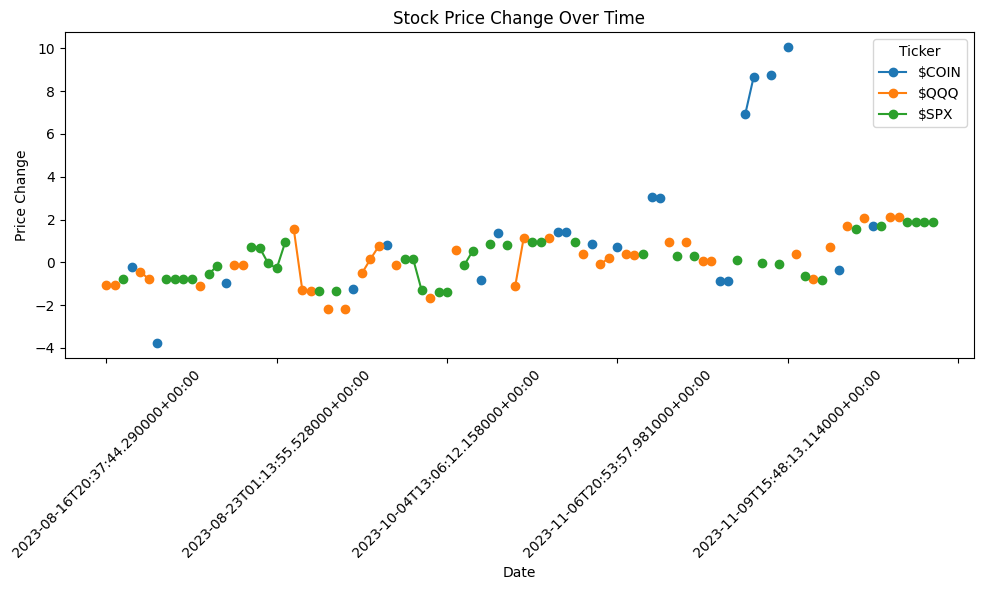

In [67]:


pivot_df = filtered_df_plot.pivot(index='timestamp', columns='tickers_mentioned', values='change_of_ticker')

# Plot the data
pivot_df.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Stock Price Change Over Time')
plt.xlabel('Date')
plt.ylabel('Price Change in percentage')
plt.legend(title='Stocks')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
from transformers import pipeline

In [ ]:
pipe = pipeline("text-classification", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")


In [ ]:
number= df['change_of_ticker'].str[3:-3]
number


10886                                                 2.59
5132                                                  1.08
1690     0.48%', '-0.04%', '+4.87%', '-1.17%', '+0.26%'...
4276                                                  3.98
12791                                                 6.26
22074                                                 0.95
8518                                                  0.02
17453                                                 0.74
1942                                                  1.83
3344                                                  0.04
18259                                                16.94
8096                                                  1.59
7424                                                  0.13
20497                                                 0.53
9561                                   0.09%', '-0.34', No
Name: change_of_ticker, dtype: object

In [ ]:
predictions = [pipe(text)[0]['label'] for text in df["tweet_text"]]
df['Sentiment'] = predictions

In [ ]:
shap_df = df[['tweet_text', 'Sentiment', 'change_of_ticker']]
shap_df

tweet_text Sentiment  \
19299                                       $TWTR HALT 👀   neutral   
14775  $QQQ\n\nNasdaq may find some support here a bi...  negative   
6061                          $SNOW REPEAT SWEEPER  ❄️❄️   neutral   
9034   $AUY $AGI $AG $EGO I think all of the miners I...  positive   
14796  $XPEV\n\nDaily triangle setup--China names hav...   neutral   
11286     $SQ #SQ give us $105? 🤑\n\nTarget $120 // $134   neutral   
7930   silver miners out to 7 year relative lows...\n...  negative   
7878   $LULU Still in the range, but it looks like it...   neutral   
1816   $TEAM higher low on the daily above the 50sma ...  negative   
18969  Little flag forming on $SPX daily. Let’s see w...   neutral   
5023   $SPX Testing the Daily 200MA (Purple).\n\nThe ...   neutral   
11116                                                $ES   neutral   
7262                  $LTRY .72 MFERS — ALMOST 100% here   neutral   
4322   $SPX Next update : 01/09/2023 - After Close. \...   neutral   
3478   It's happening ! $spy\n\nWith a 1h cloud break...   neutral   

                               change_of_ticker  
19299                                ['+5.52%']  
14775                                ['-1.96%']  
6061                                 ['-1.29%']  
9034   ['-4.44%', '-8.03%', '-6.55%', '-4.09%']  
14796                                ['-0.32%']  
11286                                ['-1.78%']  
7930                                 ['-1.37%']  
7878                                 ['-0.84%']  
1816                                 ['+2.39%']  
18969                                ['+1.38%']  
5023                                 ['+2.14%']  
11116                                ['+0.12%']  
7262                                 ['+80.0%']  
4322             ['+0.64%', '-0.08%', '-0.06%']  
3478                                 ['-0.17%']

In [ ]:
df

timestamp  \
19299                               NaN   
14775                               NaN   
6061   2022-09-12T14:21:28.097000+00:00   
9034   2022-06-03T00:11:10.364000+00:00   
14796                               NaN   
11286                               NaN   
7930   2022-07-11T17:28:24.137000+00:00   
7878   2022-07-13T12:50:09.876000+00:00   
1816   2023-05-23T13:58:54.604000+00:00   
18969  2022-06-02T18:21:54.564000+00:00   
5023   2022-11-30T20:13:54.026000+00:00   
11116                               NaN   
7262   2022-08-03T15:13:56.064000+00:00   
4322   2023-01-10T03:36:12.398000+00:00   
3478   2023-02-10T14:45:26.616000+00:00   

                                              tweet_text  \
19299                                       $TWTR HALT 👀   
14775  $QQQ\n\nNasdaq may find some support here a bi...   
6061                          $SNOW REPEAT SWEEPER  ❄️❄️   
9034   $AUY $AGI $AG $EGO I think all of the miners I...   
14796  $XPEV\n\nDaily triangle setup--China names hav...   
11286     $SQ #SQ give us $105? 🤑\n\nTarget $120 // $134   
7930   silver miners out to 7 year relative lows...\n...   
7878   $LULU Still in the range, but it looks like it...   
1816   $TEAM higher low on the daily above the 50sma ...   
18969  Little flag forming on $SPX daily. Let’s see w...   
5023   $SPX Testing the Daily 200MA (Purple).\n\nThe ...   
11116                                                $ES   
7262                  $LTRY .72 MFERS — ALMOST 100% here   
4322   $SPX Next update : 01/09/2023 - After Close. \...   
3478   It's happening ! $spy\n\nWith a 1h cloud break...   

                                               tweet_url tweet_type  \
19299  https://twitter.com/Ultra_Calls/status/1518661...      tweet   
14775  https://twitter.com/ShardiB2/status/1483448112...      tweet   
6061   https://twitter.com/ThetaWarrior/status/156933...      tweet   
9034   https://twitter.com/HackermanAce/status/153251...      tweet   
14796  https://twitter.com/Albert_trades/status/14832...      tweet   
11286  https://twitter.com/_bread911/status/151369398...      tweet   
7930   https://twitter.com/the_chart_life/status/1546...      tweet   
7878   https://twitter.com/Amdtrades/status/154720169...      tweet   
1816   https://twitter.com/rachels_44/status/16610087...      tweet   
18969  https://twitter.com/rachels_44/status/15324272...      tweet   
5023   https://twitter.com/DaanCrypto/status/15980476...      tweet   
11116  https://twitter.com/StonkTrump/status/15145850...      tweet   
7262   https://twitter.com/Ultra_Calls/status/1554848...      tweet   
4322   https://twitter.com/reciknows/status/161265448...      tweet   
3478   https://twitter.com/HackermanAce/status/162405...      tweet   

       price_of_ticker  change_of_ticker                tickers_mentioned  \
19299              NaN               NaN                        ['$TWTR']   
14775              NaN               NaN                         ['$QQQ']   
6061               NaN               NaN                        ['$SNOW']   
9034               NaN               NaN  ['$EGO', '$AG', '$AGI', '$AUY']   
14796              NaN               NaN                        ['$XPEV']   
11286              NaN               NaN                          ['$SQ']   
7930               NaN               NaN                         ['$SIL']   
7878               NaN               NaN                        ['$LULU']   
1816               NaN               NaN                        ['$TEAM']   
18969              NaN               NaN                         ['$SPX']   
5023               NaN               NaN                         ['$SPX']   
11116              NaN               NaN                        ['$ES=F']   
7262               NaN               NaN                        ['$LTRY']   
4322               NaN               NaN         ['$QQQ', '$SPX', '$SPY']   
3478               NaN               NaN                         ['$SPY']   

          

In [ ]:
explainer = shap.Explainer(pipe)
shap_values = explainer(shap_df["tweet_text"])

PartitionExplainer explainer: 11it [01:59, 11.94s/it]                        


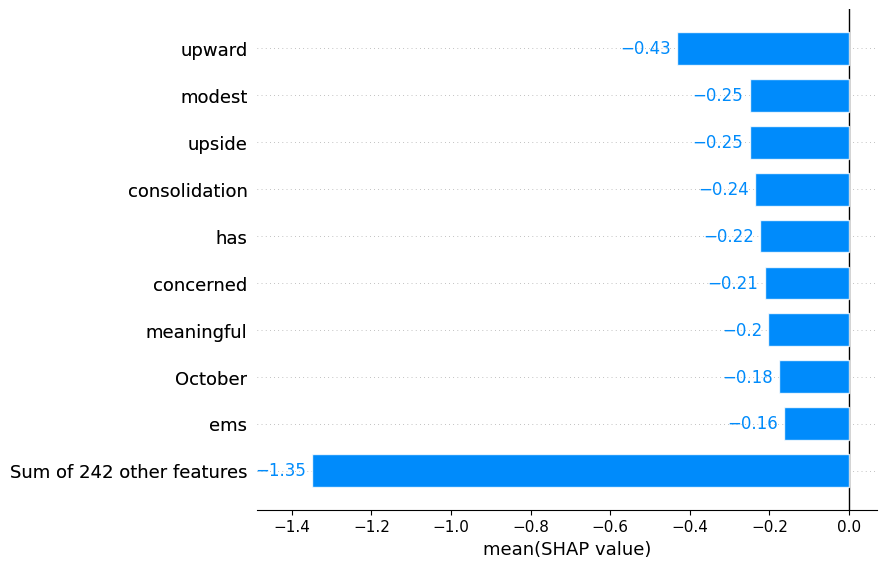

In [ ]:
shap.plots.bar(shap_values[:, :, "neutral"].mean(0), order=shap.Explanation.argsort)


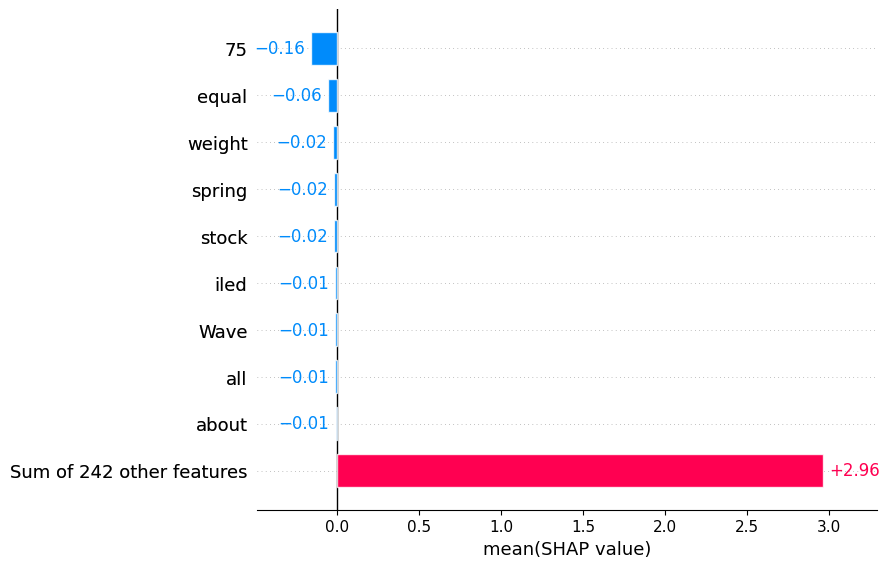

In [ ]:
shap.plots.bar(shap_values[:, :, "positive"].mean(0), order=shap.Explanation.argsort)

In [ ]:
shap.plots.text(shap_values[:, :, "positive"])

In [ ]:
shap.plots.text(shap_values)